# Generate Text Statistics in Plots
Creates a series of plots using R's GGPlot, and Python's Textstat package, and groups these to 'textstats.svg'. Also creates a plot showing the development of Readability Consensus, using the same base, saved as 'consensusplot.svg'.

In [1]:
# Enable R output through IPython using RPy2
%load_ext rpy2.ipython

# SQLite3 database
import sqlite3
# NumPy: Linear algebra, random number capabilities, multi-dimensional data-container
import numpy as np
from numpy import log
# Pandas: Data structures and data analysis tools
import pandas as pd
# Datetime, Time, and Math: Date-manipulation, time- and math-related functions
from datetime import datetime, timedelta
import time, math
# Itertools: Iterators for efficient looping
from itertools import groupby
# Collections: High-performance container datatypes
from collections import defaultdict

# Set up R environment
%R require(ggplot2)
%R require(gtable)
%R require(gridExtra)
%R require(cowplot)
%R require(ggthemes)

# RPy2: Bridge between Python and R
import rpy2.rinterface as ri
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr
base = importr('base')
stats = importr('stats')
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# R 'print' function, basic functionality
rprint = ro.globalenv.get("print")
base = importr('base')
stats = importr('stats')
datasets = importr('datasets')
grdevices = importr('grDevices')

# Enable inline display of images, including .png and .svg
from IPython.core.display import Image
from IPython.display import SVG, display
import uuid

# A simple function for returning an image inline in IPython after saving
grdevices = importr('grDevices')
def ggplot_notebook(gg, width = 800, height = 600):
    fn = '{uuid}.png'.format(uuid = uuid.uuid4())
    grdevices.png(fn, width = width, height = height)
    gg.plot()
    grdevices.dev_off()
    return Image(filename=fn)

In [2]:
# Read database, attach as Pandas dataframe
db = sqlite3.connect("Applications.db")
df = pd.read_sql_query("SELECT * FROM applications ORDER BY date(date) DESC", db)
db.close()

# Convert 'date' column to Datetime objects
df['date'] =  pd.to_datetime(df['date'], format="%Y-%m-%d")

# Group rows by date, calculate means
unique = pd.unique(df.date.ravel())
grouped = pd.DataFrame([{'date': k, 
    'flesch_reading_ease': v.flesch_reading_ease.mean(),
    'flesch_kincaid_grade': v.flesch_kincaid_grade.mean(),
    'gunning_fog': v.gunning_fog.mean(),
    'smog_index': v.smog_index.mean(),
    'automated_readability_index': v.automated_readability_index.mean(),
    'coleman_liau_index': v.coleman_liau_index.mean(),
    'linsear_write_formula': v.linsear_write_formula.mean(),
    'dale_chall_readability_score': v.dale_chall_readability_score.mean(),
    'readability_consensus' : v.readability_consensus}
    for k,v in df.groupby(['date'])], 
    columns=[
        'date',
        'flesch_reading_ease',
        'flesch_kincaid_grade',
        'gunning_fog',
        'smog_index',
        'automated_readability_index',
        'coleman_liau_index',
        'linsear_write_formula',
        'dale_chall_readability_score',
        'readability_consensus'
    ]).sort('date', 0, 0)

In [3]:
%R -i df
# Initialize the Pandas DataFrame as a R data.frame

In [4]:
%%R
# Function for plotting histograms
textstat_histogram <- function(df, column, title = "Plot Title", xlabel = "Description", bw = FALSE) {
    if (bw) {fillcolor = 'grey'} else {fillcolor = 'cyan'}
    result <- ggplot(df, aes_string(x = column)) + 
        geom_histogram(aes(y=..density.., fill=..count..), binwidth=1) +
        geom_density(alpha=0.2, fill=fillcolor) +
        ggtitle(title) +
        labs(y = "Density", x = xlabel, fill = "")
    if (bw) {result = result + scale_fill_gradient(low="grey", high="black")}
    result = result + theme(plot.title = element_text(size = rel(1.2), vjust=2),
                      axis.title.x=element_text(vjust=0),
                      axis.title.y=element_text(vjust=1.5),
                      legend.position="none",
                      plot.margin=unit(c(.6,.3,.6,.3),"cm"))
    return(result)
}

In [5]:
%%R
# Nested list of Textstat plots
blackwhite = FALSE
textstats <- list()
textstats[["flesch_reading_ease"]] <- textstat_histogram(df, "flesch_reading_ease", "Flesch Reading Ease", "0 is Confusing, 100 is Easy", blackwhite)
textstats[["flesch_kincaid_grade"]] <- textstat_histogram(df, "flesch_kincaid_grade", "Flesch-Kincaid Grade Level", "Grade level needed to read the text", blackwhite)
textstats[["gunning_fog"]] <- textstat_histogram(df, "gunning_fog", "Gunning FOG Index", "Ideal readability score", blackwhite)
textstats[["smog_index"]] <- textstat_histogram(df, "smog_index", "SMOG Index", "Grade level needed to understand the text", blackwhite)
textstats[["automated_readability_index"]] <- textstat_histogram(df, "automated_readability_index", "Automated Readability Index", "Grade level needed to comprehend the text", blackwhite)
textstats[["coleman_liau_index"]] <- textstat_histogram(df, "coleman_liau_index", "Coleman-Liau Index", "Grade level of the text", blackwhite)
textstats[["linsear_write_formula"]] <- textstat_histogram(df, "linsear_write_formula", "Linsear Write Formula", "Grade level of the text", blackwhite)
textstats[["dale_chall_readability_score"]] <- textstat_histogram(df, "dale_chall_readability_score", "Dale-Chall Readability Score", "Grade level of the text", blackwhite)

In [6]:
%%R
# Group the figures using cowplot plot.grid()
grid <- plot_grid(
    textstats$"flesch_reading_ease",
    textstats$"flesch_kincaid_grade",
    textstats$"gunning_fog",
    textstats$"smog_index",
    textstats$"automated_readability_index",
    textstats$"coleman_liau_index",
    textstats$"linsear_write_formula",
    textstats$"dale_chall_readability_score",
    ncol = 2,
    align = "hv")
ggsave(file = "textstats.svg", path = "Plots", plot = grid, width = 10, height = 8, dpi = 100)

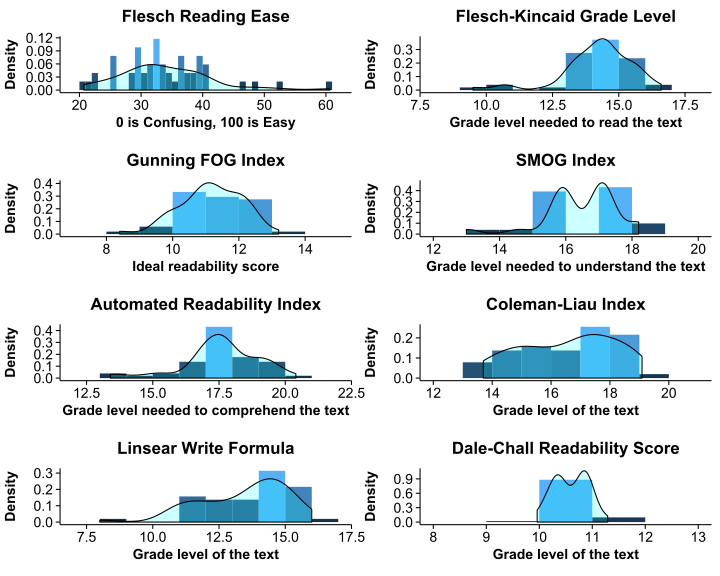

In [7]:
# Display the complete Textstats plot
display(SVG(filename='Plots/textstats.svg'))

In [8]:
consensus = []
for grade in df['readability_consensus']:
    grade = grade.replace('th', '').replace(' grade', '').replace(' and ', '-')
    numbers = grade.split('-')
    numbers = [int(i) for i in numbers]
    numbers_mean = np.mean(numbers)
    consensus.append(numbers_mean)
df["consensus_mean"] = consensus

In [9]:
# Group rows by date, calculate means
consensus_unique = pd.unique(df.date.ravel())
consensus_grouped = pd.DataFrame([{'date': k, 
            'consensus_mean' : v.consensus_mean.mean()}
    for k,v in df.groupby(['date'])], 
    columns=[
        'date',
        'consensus_mean'
    ]).sort('date', 0, 0)

In [10]:
%R -i consensus_grouped

In [11]:
%%R
# Initialize R and define variables
pointsize <- 3 # Define a pointsize for use in scatter plots
colour_cutoff <- 5 # Define a default cutoff for colour scales

In [12]:
%%R
# Initialize R and plot Grade level per day
blackwhite = FALSE
consensusplot <- ggplot(data = consensus_grouped, aes
                    (x = date, 
                    y = consensus_mean, 
                    colour = cut(consensus_mean, colour_cutoff))) +
    geom_point(size = pointsize) +
    stat_smooth(aes(group = 1), method = "lm", size = 1, color = "grey50", alpha = 0.1) +
    labs(y = "Grade level", x = "") +
    ggtitle("Development of required comprehension") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          legend.position="none",         
          plot.title = element_text(size = rel(1.5), vjust=3),
          plot.margin = unit(c(1,0.5,0.5,0.5), "cm"),
          axis.title.y=element_text(vjust=1.5))
if (blackwhite) {
    consensusplot = consensusplot + scale_colour_grey()
} else {
    consensusplot = consensusplot + scale_colour_brewer(type = "div", palette = 5)
}
ggsave(file = "consensusplot.svg", path = "Plots", plot = consensusplot, width = 10, height = 8, dpi = 100)

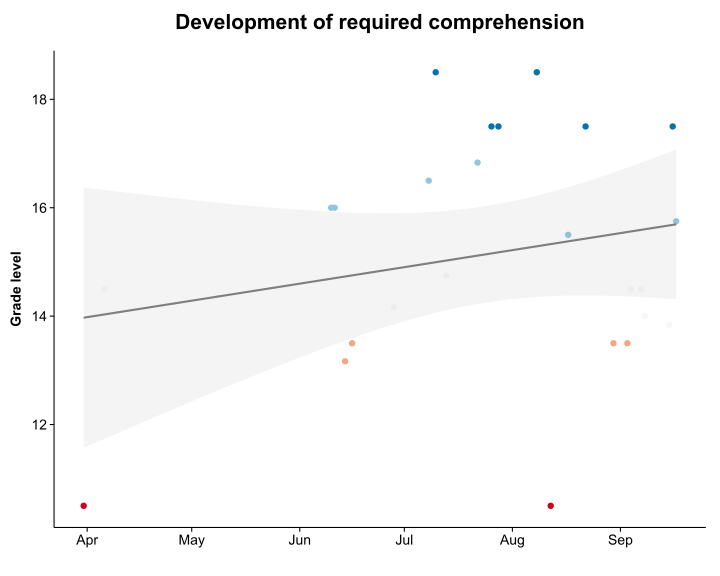

In [13]:
# Display the complete Consensus plot
display(SVG(filename='Plots/consensusplot.svg'))